## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Load Data
- Exploration
- Text Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

### Load Data

In [116]:
# Import modules
import pandas as pd
import numpy as np
import re

In [117]:
# Load dataset
quora = pd.read_csv('train.csv')
quora.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [118]:
# Filter and rename columns
quora = quora[['question1','question2','is_duplicate']]
quora.columns = ['Q1','Q2','Is_Duplicate']

quora.head()

,Q1,Q2,Is_Duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [119]:
quora.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Q1            404289 non-null  object
 1   Q2            404288 non-null  object
 2   Is_Duplicate  404290 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 9.3+ MB


In [120]:
# Check for number of rows where the question is a duplicate
len(quora[quora['Is_Duplicate'] == 1])

149263

After examining the dataset, we can see that:
* Is_Duplicate == 0 means that the row for question 1 and question 2 are not duplicates
* Is_Duplicate == 1 means that the row for question 1 and question 2 are duplicates are very similar

In [121]:
# Check for nulls
quora.isna().sum()

Q1              1
Q2              2
Is_Duplicate    0
dtype: int64

In [122]:
# Examine null rows
quora[quora['Q1'].isna()]

,Q1,Q2,Is_Duplicate
363362,NaN,My Chinese name is Haichao Yu. What English na...,0


In [123]:
# Examine null rows
quora[quora['Q2'].isna()]

,Q1,Q2,Is_Duplicate
105780,How can I develop android app?,NaN,0
201841,How can I create an Android app?,NaN,0


Let's drop these rows, as we need a pair of questions to discern if it has a duplicate or not to train our model. Thus, these rows are unhelpful as it is a single question with no pair, making them irrelevant for our model.

In [124]:
# Drop nulls
quora.dropna(inplace=True)

# Confirm removal
print(quora.shape)
quora.isna().sum()

(404287, 3)


Q1              0
Q2              0
Is_Duplicate    0
dtype: int64

### Exploration

We can visualize the statistics of the dataset using histograms and bar graphs to help interpret the data. We can conduct analysis on statistics such as:
- Number of characters in each question
- Number of words in each question
- View the top stopwords
- View the top words that appear

We will conduct some light pre-cleaning to allow for more intuitive results by:
- Converting text columns to string dtype
- Removing uppercase
- Removing punctuation

In [125]:
# Load modules
from nltk.corpus import stopwords
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [126]:
# Change columns to string
quora['Q1'] = quora['Q1'].astype(str)
quora['Q2'] = quora['Q2'].astype(str)

# Remove punctuation
quora['Q1'] = quora['Q1'].str.replace('[^\w\s]','', regex=True)
quora['Q2'] = quora['Q2'].str.replace('[^\w\s]','', regex=True)

# Remove uppercase
quora['Q1'] = quora['Q1'].str.lower()
quora['Q2'] = quora['Q2'].str.lower()

#### Number of Characters in Each Question

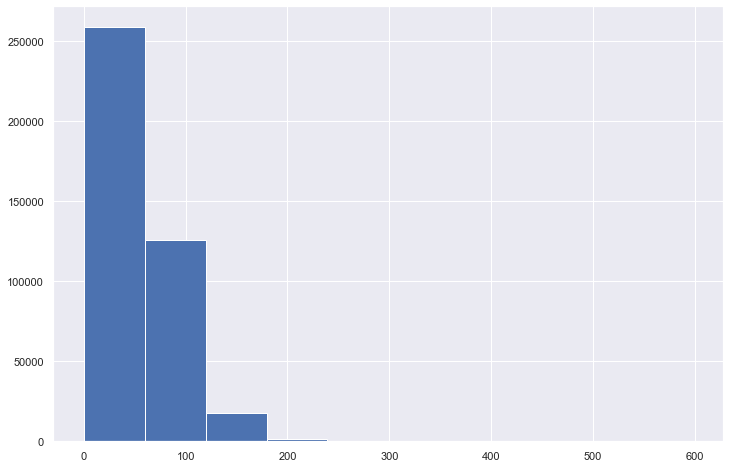

In [127]:
# Q1
quora['Q1'].str.len().hist(figsize=(12,8));

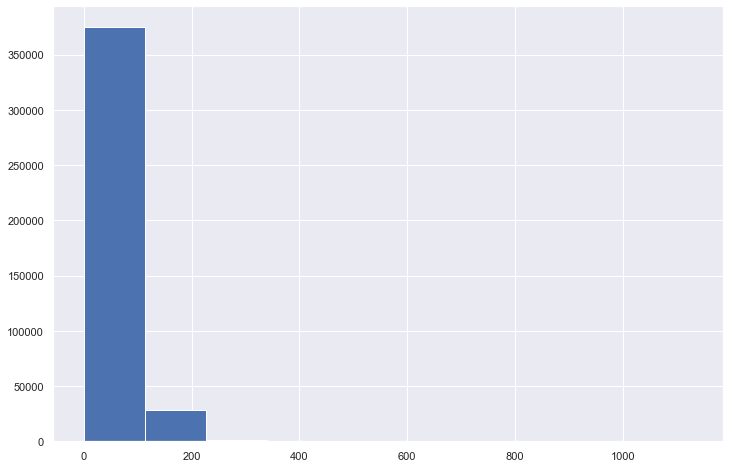

In [128]:
# Q2
quora['Q2'].str.len().hist(figsize=(12,8));

#### Number of Words in Each Question

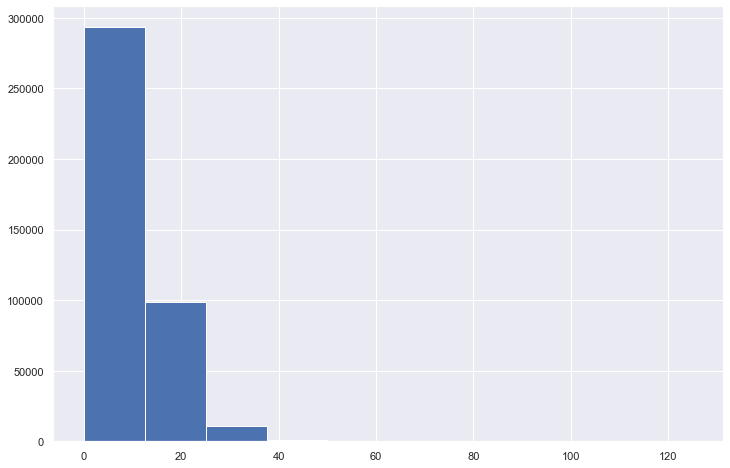

In [129]:
# Q1
quora['Q1'].str.split().map(lambda x: len(x)).hist(figsize=(12,8));

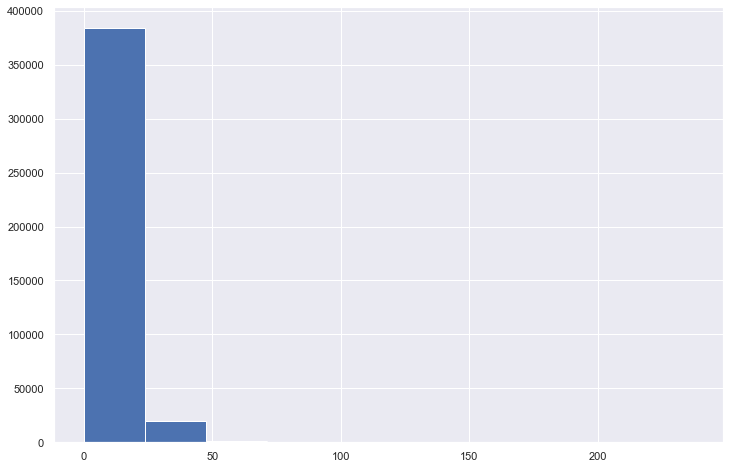

In [130]:
# Q2
quora['Q2'].str.split().map(lambda x: len(x)).hist(figsize=(12,8));

#### Top Stopwords

In [131]:
stop = stopwords.words('english')

corpus = []
count = quora['Q1'].str.split()
count = count.values.tolist()
corpus = [word for i in count for word in i]

from collections import defaultdict

dict=defaultdict(int)
for word in corpus:
    if word in stop:
        dict[word]+=1

top=sorted(dict.items(), key=lambda x:x[1],reverse=True)[:10] 

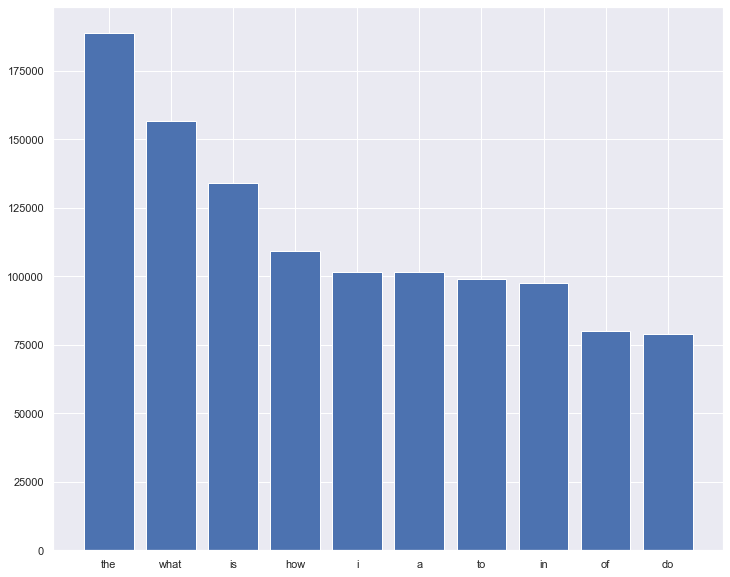

In [132]:
x,y=zip(*top)
fig = plt.gcf()
fig.set_size_inches(12,10)
plt.bar(x,y);

In [133]:
# Q2
corpus = []
count = quora['Q2'].str.split()
count = count.values.tolist()
corpus = [word for i in count for word in i]

from collections import defaultdict

dict=defaultdict(int)
for word in corpus:
    if word in stop:
        dict[word]+=1

top=sorted(dict.items(), key=lambda x:x[1],reverse=True)[:10] 

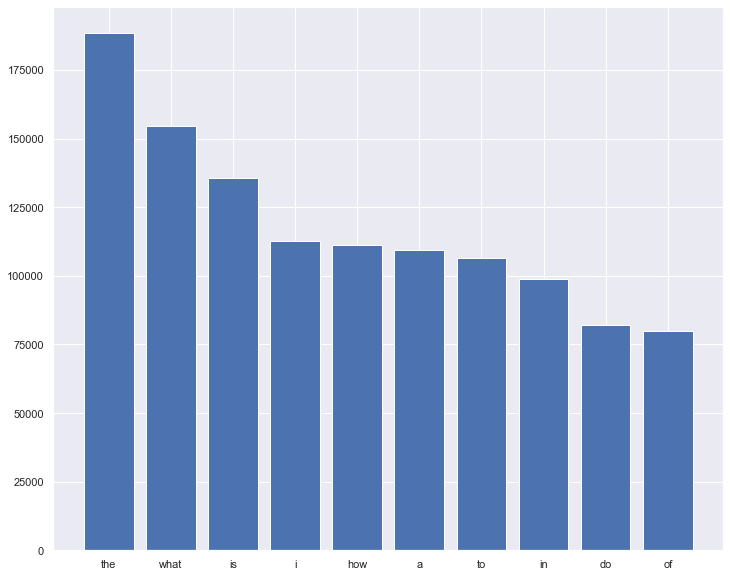

In [134]:
x,y=zip(*top)
fig = plt.gcf()
fig.set_size_inches(12,10)
plt.bar(x,y);

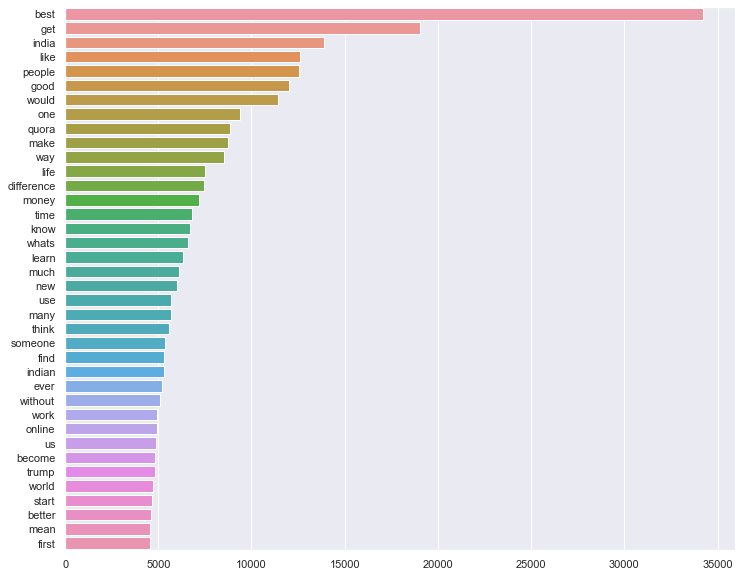

In [135]:
# Q1
texts = quora['Q1'].str.split()
texts = texts.values.tolist()
corpus = [word for i in texts for word in i]

counter = Counter(corpus)
most = counter.most_common()

x, y = [], []
for word, count in most[:100]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.set(rc={'figure.figsize':(12,10)})
sns.barplot(x=y,y=x);

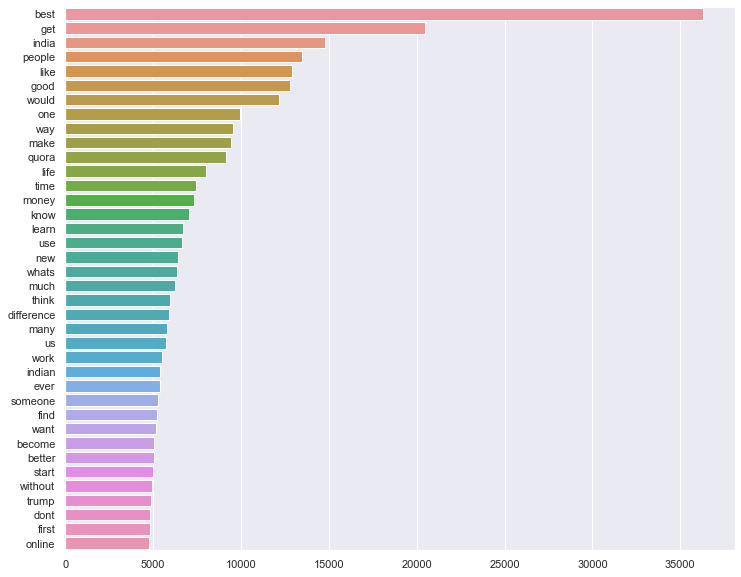

In [136]:
# Q2
texts = quora['Q2'].str.split()
texts = texts.values.tolist()
corpus = [word for i in texts for word in i]

counter = Counter(corpus)
most = counter.most_common()

x, y = [], []
for word, count in most[:100]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.set(rc={'figure.figsize':(12,10)})
sns.barplot(x=y,y=x);

### Cleaning

Now that we have a better idea of our data and made some changes to the structure of our data, let us now cleaning the actual text portion of our data. This will focus on cleaning the actual text through several techniques to prepare it for our model. These techniques include:
- Tokenization
- Removing stopwords
- Normalizing (Stemming or Lemmatization)

- https://stackoverflow.com/questions/33098040/how-to-use-word-tokenize-in-data-frame
- https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
- https://towardsdatascience.com/text-normalization-for-natural-language-processing-nlp-70a314bfa646
- https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [137]:
# Import modules
import nltk

In [138]:
# Tokenization by space (1m17s)
tokens = nltk.word_tokenize

quora['Q1'] =  quora.apply(lambda x: nltk.word_tokenize(x['Q1']), axis=1)
quora['Q2'] =  quora.apply(lambda x: nltk.word_tokenize(x['Q2']), axis=1)

In [139]:
# Remove punctuation with list comprehension (2s)
quora['Q1'] = quora['Q1'].apply(lambda x: [text for text in x if text.isalpha()])
quora['Q2'] = quora['Q2'].apply(lambda x: [text for text in x if text.isalpha()])

In [140]:
# Remove stop words with list comprehension (12.9s)
stop = stopwords.words('english')

quora['Q1'] = quora['Q1'].apply(lambda x: [text for text in x if text not in stop])
quora['Q2'] = quora['Q2'].apply(lambda x: [text for text in x if text not in stop])

In [141]:
quora.head()

,Q1,Q2,Is_Duplicate
0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0
1,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh...",0
2,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",0
3,"[mentally, lonely, solve]","[find, remainder, divided]",0
4,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0


#### Normalization
There are 2 main techniques used to normalize text data - stemming and lemmatization. Let's see which is more optimal for our use-case, as well as how many additional letters are removed after each technique is executed.

In [142]:
# Prepare normalization DataFrames

quora_stem = quora.copy()
quora_lam = quora.copy()

In [143]:
# Use stemming to normalize text using snowball stemmer(48.1s)
from nltk.stem import SnowballStemmer
ps = SnowballStemmer('english')

quora_stem['Q1'] = quora_stem['Q1'].apply(lambda x: [ps.stem(words_sent) for words_sent in x])
quora_stem['Q2'] = quora_stem['Q2'].apply(lambda x: [ps.stem(words_sent) for words_sent in x])

In [144]:
# Use lammetization to normalize text using wordnet lemmatizer (16.8s)
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

quora_lam['Q1'] = quora_lam['Q1'].apply(lambda x: [lemmatizer.lemmatize(text) for text in x])
quora_lam['Q2'] = quora_lam['Q2'].apply(lambda x: [lemmatizer.lemmatize(text) for text in x])

Let's look at comparison of all 3 DataFrames - Quora (before any normalization), quora_stem (using stemming), and quora_lam (using lammetization).

In [145]:
# Original Quora DataFrame
q = []
df = quora['Q1']

for row in df:
    for word in row:
        for letter in word:
            q.append(letter)
print('Total letters:', len(q))

quora.head()

Total letters: 13061395


,Q1,Q2,Is_Duplicate
0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0
1,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh...",0
2,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",0
3,"[mentally, lonely, solve]","[find, remainder, divided]",0
4,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0


In [146]:
# Quora DataFrame using stemming
stem = []
df = quora_stem['Q1']

for row in df:
    for word in row:
        for letter in word:
            stem.append(letter)
print('Total letters:', len(stem))

quora_stem.head()

Total letters: 11372836


,Q1,Q2,Is_Duplicate
0,"[step, step, guid, invest, share, market, india]","[step, step, guid, invest, share, market]",0
1,"[stori, kohinoor, kohinoor, diamond]","[would, happen, indian, govern, stole, kohinoo...",0
2,"[increas, speed, internet, connect, use, vpn]","[internet, speed, increas, hack, dns]",0
3,"[mental, lone, solv]","[find, remaind, divid]",0
4,"[one, dissolv, water, quik, sugar, salt, metha...","[fish, would, surviv, salt, water]",0


In [147]:
# Quora DataFrame using lammetization
lam = []
df = quora_lam['Q1']

for row in df:
    for word in row:
        for letter in word:
            lam.append(letter)
print('Total letters:', len(lam))

quora_lam.head()

Total letters: 12781798


,Q1,Q2,Is_Duplicate
0,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0
1,"[story, kohinoor, kohinoor, diamond]","[would, happen, indian, government, stole, koh...",0
2,"[increase, speed, internet, connection, using,...","[internet, speed, increased, hacking, dns]",0
3,"[mentally, lonely, solve]","[find, remainder, divided]",0
4,"[one, dissolve, water, quikly, sugar, salt, me...","[fish, would, survive, salt, water]",0


In [148]:
len(stem)-len(lam)

-1408962

After analysis, we can observe that:
- Stemming takes 48.1 seconds to normalize the data, while lammetization takes only 16.8 seconds
- Stemming removes 1376549 additional letters than lammetization does, which means we are losing more data, potentially affecting our model
- Stemming with the snowball stemmer method, seems to be more inaccurate than the wordnet lemmatizer, as we are left with words such as 'increas' instead of 'increase', or 'dissolve' instead of 'dissolve', potentially affecting our model

In conclusion, for our normalization procedure, we will go forward and apply lammetization!

In [149]:
# Create a new cleaned DataFrame
quora_c = quora_lam.copy()

### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc